In [1]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(SingleCellExperiment)
    library(tidyverse)
    library(reticulate)
    library(batchelor)
    library(BiocParallel)
    library(logger)
    library(showtext)
    library(patchwork)
})
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

In [45]:
log_info("Reading SCE object...")
sce_complete <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.rds")
log_info("SCE object done")

In [46]:
sce <- sce_complete[, sce_complete$leiden_global_celltype == "Mesenchyme"]
sce <- logNormCounts(sce)

# Feature Selection

In [47]:
keep <- rowData(sce)$Biotype == "protein_coding"
dec <- modelGeneVar(sce, subset.row = keep, min.mean = 1, density.weights=TRUE)
hvgs <- getTopHVGs(dec, n = 3000)

# Clustering by scanpy

In [71]:
adata_sce <- zellkonverter::SCE2AnnData(sce, X_name = "logcounts")
sc <- import("scanpy")
adata_sce$var['highly_variable'] <- rownames(adata_sce$var) %in% hvgs
log_info("Run PCA")
sc$tl$pca(adata_sce, use_highly_variable=TRUE)

In [ ]:
mt_pca <- adata_sce$obsm['X_pca']

In [72]:
mnn_out <- reducedMNN(mt_pca, batch = sce$donor, auto.merge = TRUE, k=10, BPPARAM = MulticoreParam(workers = 12))

Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped a

In [73]:
adata_sce$obsm$update(X_mnn = mnn_out$corrected)
sc$pp$neighbors(adata_sce, n_pcs = 50L, use_rep = "X_mnn" )
log_info("Run UMAP")
sc$tl$umap(adata_sce)
sc$tl$draw_graph(adata_sce)
sc$tl$leiden(adata_sce, resolution = 1)
log_info("Convert back to sce")
sce <- zellkonverter::AnnData2SCE(adata_sce)

Note: Using stored X_name value 'logcounts'



In [74]:
reducedDim(sce, "PCA") <- reducedDim(sce, "X_pca")
reducedDim(sce, "UMAP") <- reducedDim(sce, "X_umap")


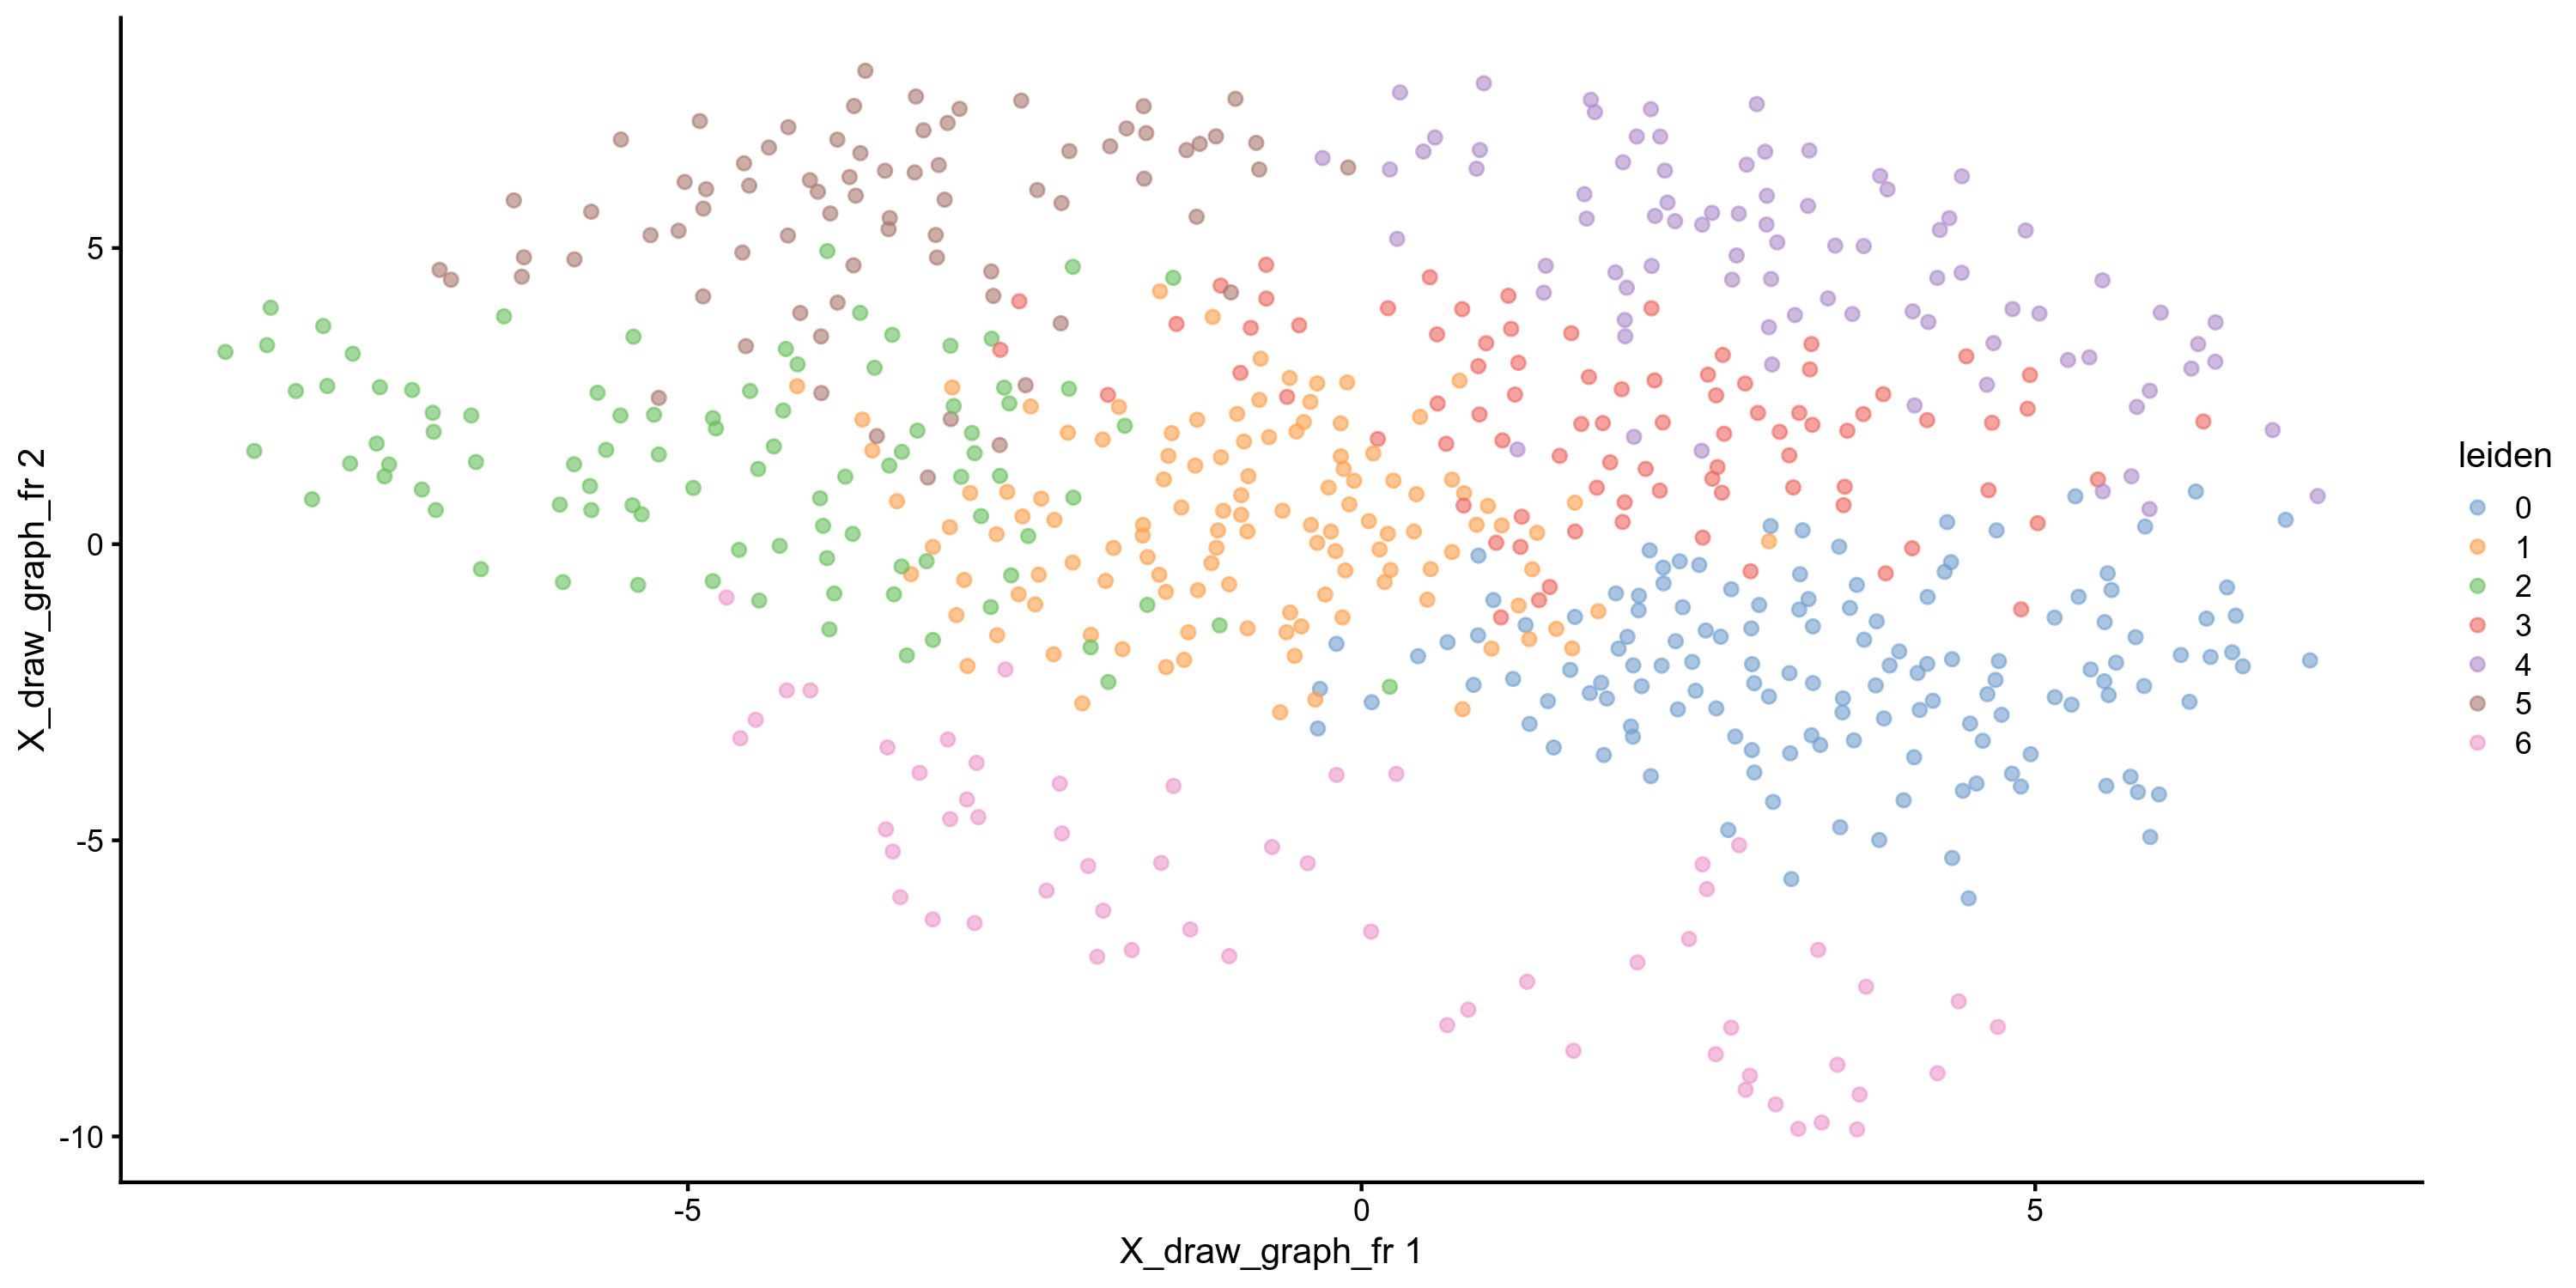

In [78]:
plotReducedDim(sce, dimred = "X_draw_graph_fr", colour_by = 'leiden')

In [76]:
reducedDimNames(sce)

[1] "PCA"             "UMAP"            "X_pca"           "X_pca_harmony"  
[5] "X_umap"          "X_draw_graph_fr" "PCA_harmony"     "X_mnn"

In [53]:
reducedDim(sce, "PCA_harmony") <- reducedDim(sce, "X_pca_harmony")
reducedDim(sce, "UMAP") <- reducedDim(sce, "X_umap")

In [79]:
sce_caf <- readRDS("../../../data/expression/sce/archive/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_stromal_caf.rds")
colData(sce)[colnames(sce_caf), "old_anno"] <- as.character(sce_caf$leiden_sub_anno)

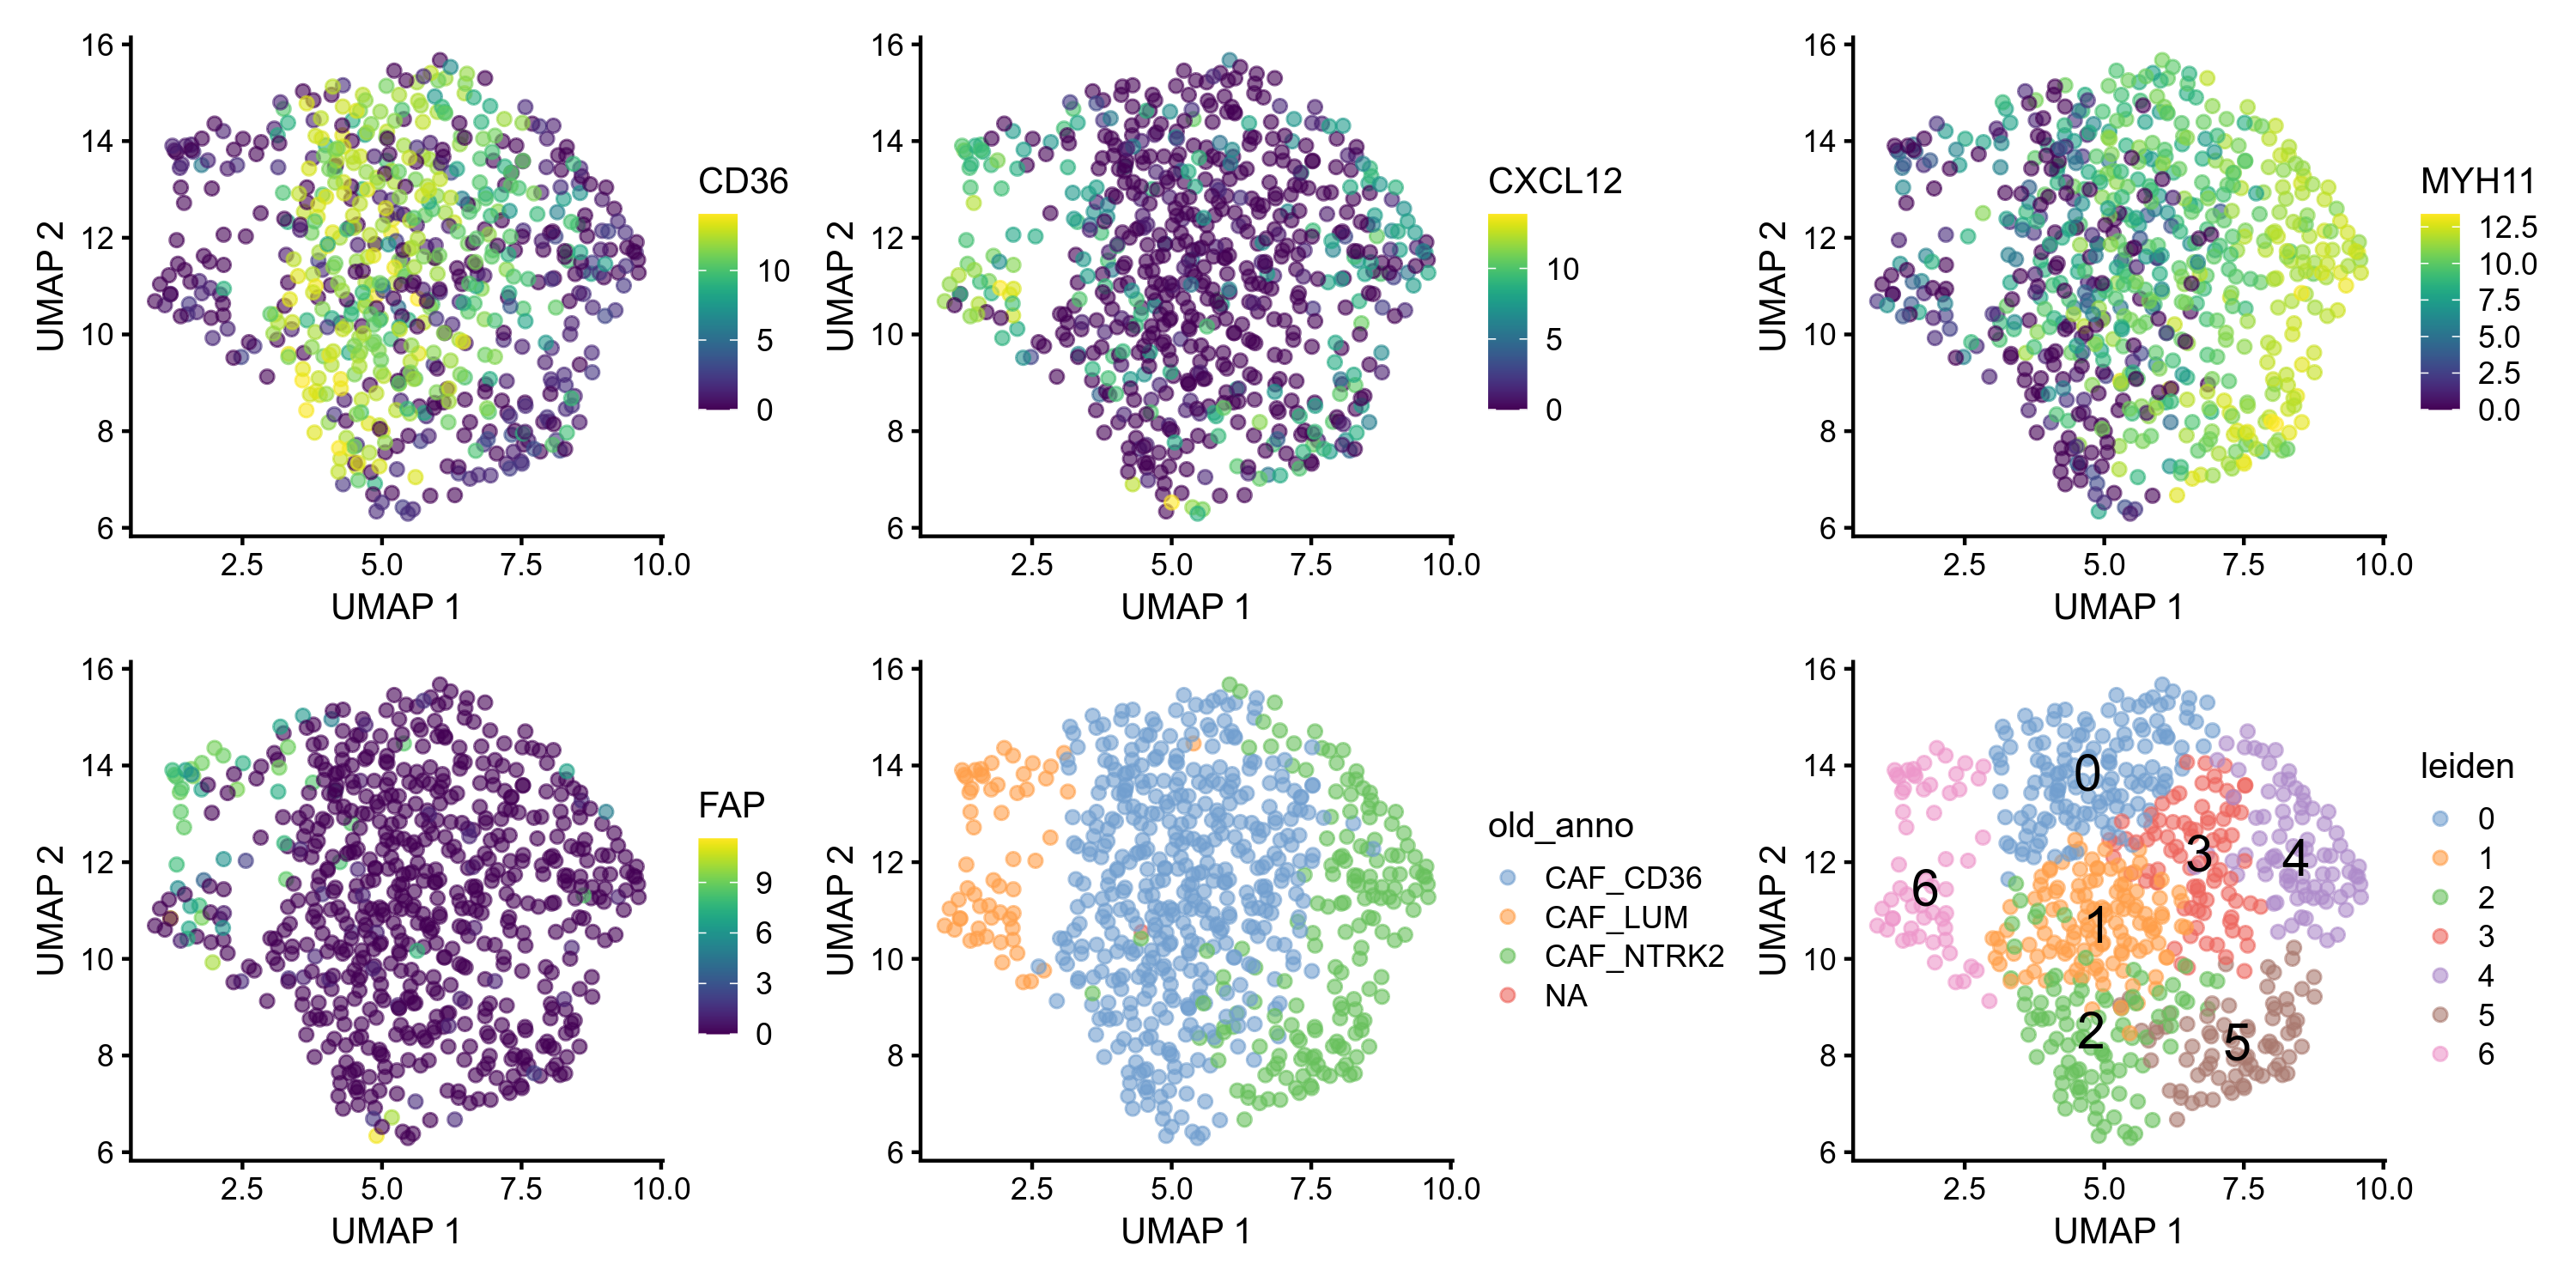

In [82]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = 'CD36')
p2 <- plotUMAP(sce, colour_by = 'CXCL12')
p3 <- plotUMAP(sce, colour_by = 'MYH11')
p4 <- plotUMAP(sce, colour_by = 'FAP')
p5 <- plotUMAP(sce, colour_by = 'old_anno')
p6 <- plotUMAP(sce, colour_by = 'leiden', text_by = 'leiden')


p1 + p2 + p3 + p4 + p5 + p6

In [84]:
leiden2celltype <- c(
    '0' = 'CAF_C02-CD36',
    '1' = 'CAF_C02-CD36',
    '2' = 'CAF_C02-CD36',
    '3' = 'CAF_C02-CD36',
    '4' = 'VSMC_C03-MYH11',
    '5' = 'VSMC_C03-MYH11',
    '6' = 'CAF_C01-FAP'
)
sce$leiden_anno <- plyr::mapvalues(x = sce$leiden, from = names(leiden2celltype), to = leiden2celltype)

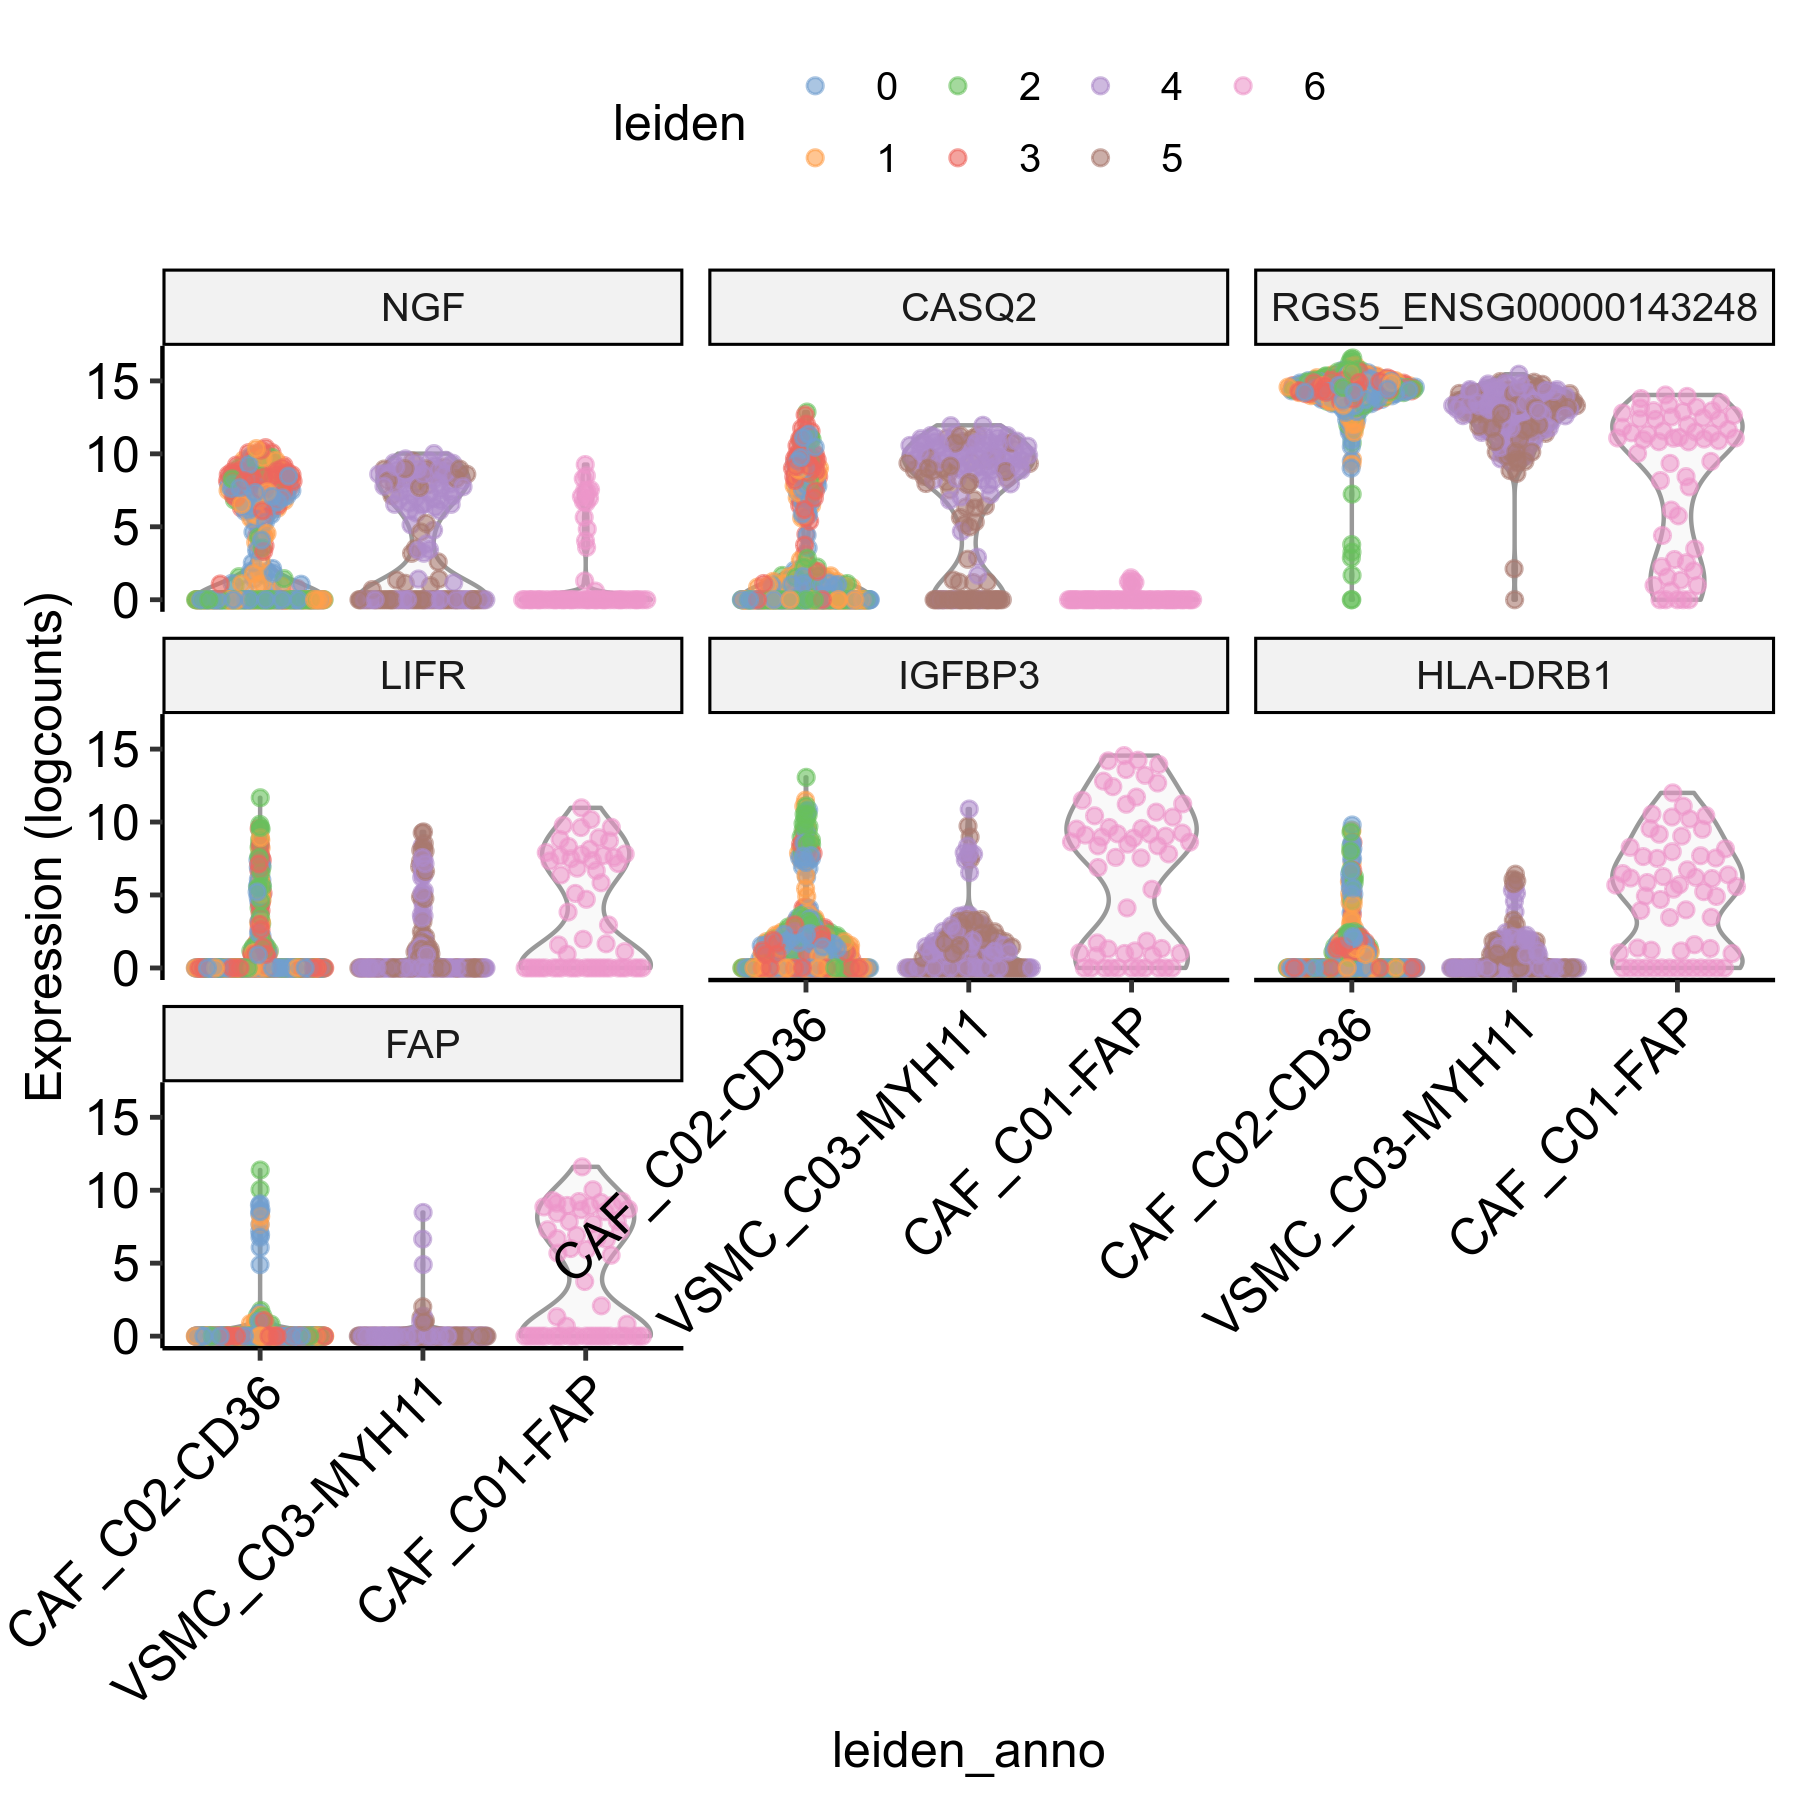

In [86]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)

plotExpression(sce, x = "leiden_anno", features = c("NGF", "CASQ2", "RGS5_ENSG00000143248", "LIFR", "IGFBP3", "HLA-DRB1", "FAP"), colour_by = "leiden", ncol = 3) + 
    ggpubr::theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

In [90]:
keep <- rowData(sce)$Biotype == 'protein_coding'
markers <- findMarkers(sce, groups = sce$leiden_anno, lfc = 1, direction = 'up', subset.row = keep)
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df[which(df$Top <= 30),]
})

In [91]:
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df[which(df$Top <= 30),]
})

In [93]:
openxlsx::write.xlsx(top_markers, "./output/TopMarkers_mesenchyme.xlsx")

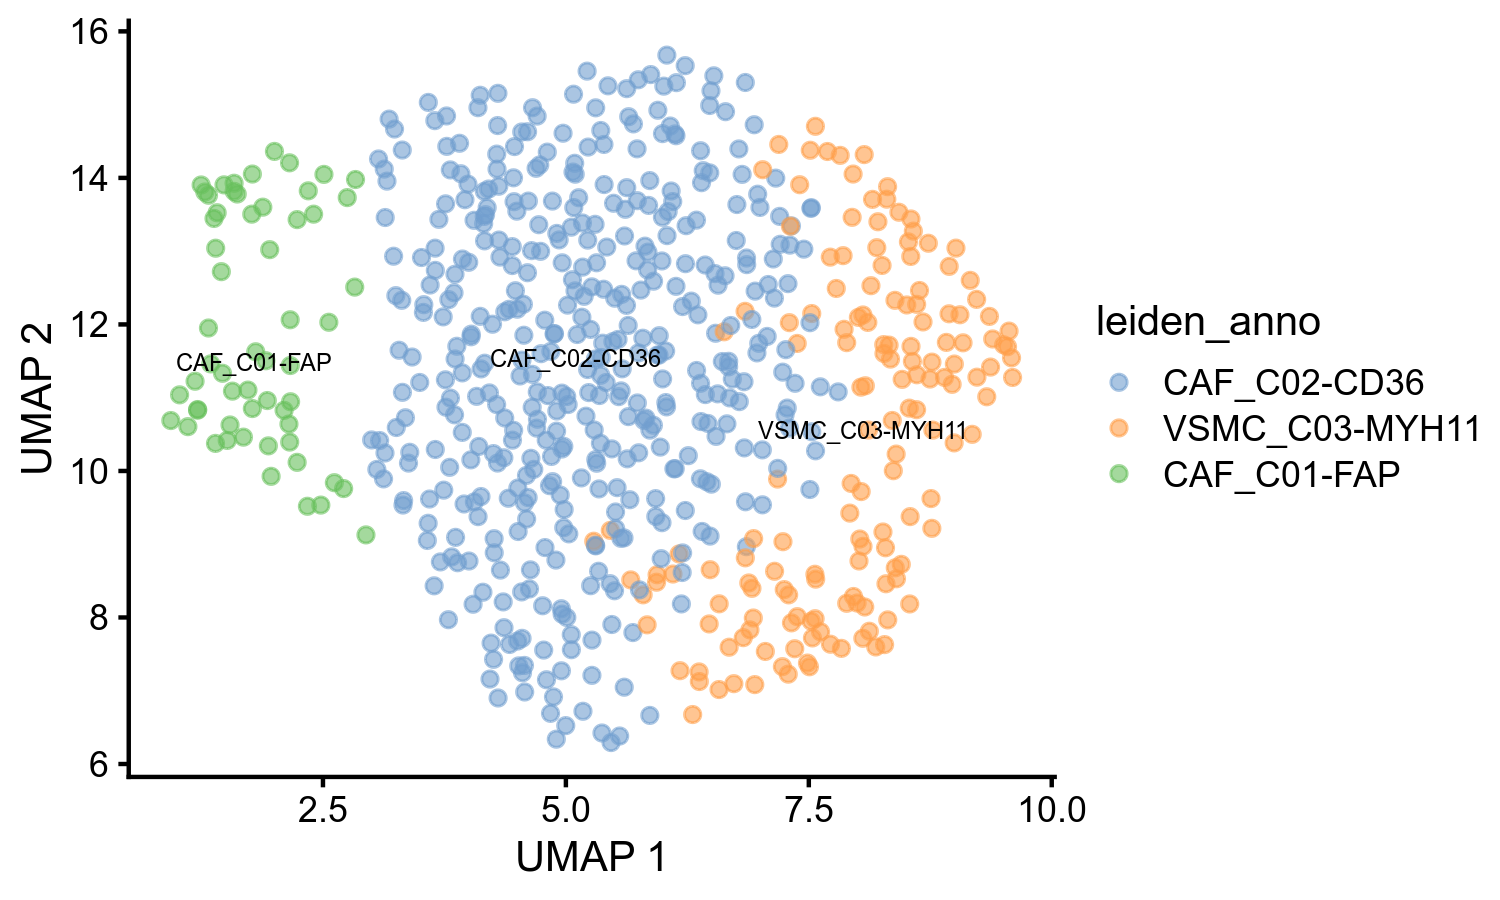

In [88]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)
plotUMAP(sce, colour_by = "leiden_anno", text_by = "leiden_anno", text_size = 2)

In [89]:
saveRDS(sce, file = "../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_mesenchyme.rds")

In [2]:
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_mesenchyme.rds")

In [4]:
sce <- sce[, grep("^CAF", sce$leiden_anno)]

In [6]:
sce$leiden_anno <- as.character(sce$leiden_anno)

In [22]:
keep <- rowData(sce)$Biotype == 'protein_coding'
sce <- sce[keep,]

In [63]:
exprDF <- makePerCellDF(sce, features = rownames(sce), assay.type = "logcounts")
exprDF <- exprDF %>% 
    select(leiden_anno, rownames(sce)) %>% 
    pivot_longer(cols = rownames(sce) , names_to = "gene",  values_to = "logcounts") %>%
    group_by(leiden_anno, gene) %>%
    summarise( fractionExpr = sum(logcounts > 0)/n(), meanExpr = mean(logcounts) )

`summarise()` has grouped output by 'leiden_anno'. You can override using the `.groups` argument.



In [68]:
exprDF[exprDF$gene == 'LUM',]

leiden_anno  gene fractionExpr meanExpr 
1 CAF_C01-FAP  LUM  0.9655172    11.865300
2 CAF_C02-CD36 LUM  0.3770115     2.621255

In [67]:
exprDF[exprDF$gene == 'CCL21',]

leiden_anno  gene  fractionExpr meanExpr
1 CAF_C01-FAP  CCL21 0.6551724    5.413488
2 CAF_C02-CD36 CCL21 0.2298851    1.276825

In [66]:
exprDF[exprDF$gene == 'CCL19',]

leiden_anno  gene  fractionExpr meanExpr
1 CAF_C01-FAP  CCL19 0.4310345    4.062934
2 CAF_C02-CD36 CCL19 0.1678161    0.623146

In [23]:
keep <- calculateAverage(sce) > 1

In [56]:
markers <- findMarkers(sce, groups = sce$leiden_anno, block = sce$donor, lfc = 0, direction = 'up', subset.row = keep)

In [57]:
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df <- df[df$summary.logFC > 3 & df$FDR < 0.01,]
    df
    #df[which(df$Top <= 50),]
})

In [60]:
markers$`CAF_C01-FAP`['FAP',]

DataFrame with 1 row and 5 columns
          Top     p.value         FDR summary.logFC logFC.CAF_C02-CD36
    <integer>   <numeric>   <numeric>     <numeric>          <numeric>
FAP        91 5.20325e-09 7.81974e-07       3.79727            3.79727

In [58]:
markers$`CAF_C01-FAP`['CCL19',]

DataFrame with 1 row and 5 columns
            Top     p.value         FDR summary.logFC logFC.CAF_C02-CD36
      <integer>   <numeric>   <numeric>     <numeric>          <numeric>
CCL19       202 9.56563e-06 0.000647621       3.31704            3.31704

In [59]:
markers$`CAF_C01-FAP`['CCL21',]

DataFrame with 1 row and 5 columns
            Top    p.value         FDR summary.logFC logFC.CAF_C02-CD36
      <integer>  <numeric>   <numeric>     <numeric>          <numeric>
CCL21       129 1.4442e-07 1.53107e-05       3.89838            3.89838

In [70]:
openxlsx::write.xlsx(top_markers, file = "./output/TopMarkers_mesenchyme_CAF_lfc3_FDR0.01.xlsx")

In [69]:
top_markers$`CAF_C01-FAP`

gene     Top p.value      FDR          summary.logFC
LUM      LUM       1  2.832090e-66 3.873167e-62 8.144757     
THBS2    THBS2     2  7.843070e-49 5.363091e-45 5.790572     
C7       C7        3  3.722317e-40 1.696880e-36 6.884368     
SERPINF1 SERPINF1  4  8.566195e-40 2.928782e-36 5.356618     
VCAN     VCAN      5  3.231108e-32 8.837726e-29 6.889030     
ENG      ENG       6  5.970460e-30 1.360867e-26 3.611042     
CCDC80   CCDC80    7  1.494504e-27 2.919833e-24 4.913005     
EFEMP1   EFEMP1    8  9.639981e-25 1.647955e-21 8.488369     
EFEMP2   EFEMP2    9  6.978815e-24 1.060470e-20 3.204783     
PMP22    PMP22    10  1.920054e-23 2.625866e-20 3.240419     
CTSK     CTSK     11  2.654839e-23 3.300689e-20 4.814569     
DCN      DCN      12  2.517156e-22 2.868719e-19 4.084611     
RARRES2  RARRES2  15  2.957833e-21 2.696755e-18 3.890931     
SPON2    SPON2    18  3.239326e-20 2.461168e-17 4.289937     
FMOD     FMOD     20  6.770899e-19 4.629941e-16 4.713525     
LAMA2    LAMA2    22  1.573483e-17 9.781339e-15 4.875853     
ISLR     ISLR     23  1.806763e-17 1.074317e-14 5.305068     
C1S      C1S      24  2.068350e-17 1.178615e-14 3.735395     
BICC1    BICC1    26  2.332036e-17 1.226651e-14 4.942946     
LRP1     LRP1     27  1.576042e-16 7.982943e-14 3.483241     
MMP2     MMP2     28  2.587443e-16 1.263781e-13 5.561036     
GPC3     GPC3     29  4.942075e-16 2.330614e-13 4.939207     
MFAP4    MFAP4    30  7.767000e-16 3.540717e-13 6.960196     
OLFML3   OLFML3   31  1.028188e-15 4.535967e-13 4.863511     
CYP1B1   CYP1B1   32  2.508010e-15 1.071861e-12 4.446755     
AEBP1    AEBP1    33  3.806872e-15 1.577660e-12 4.049638     
QSOX1    QSOX1    34  8.634908e-15 3.473265e-12 4.108583     
CXCL12   CXCL12   35  1.814390e-14 7.089601e-12 6.387429     
ABI3BP   ABI3BP   36  1.931159e-14 7.336258e-12 5.982275     
FBLN5    FBLN5    37  2.054370e-14 7.593396e-12 6.404218     
⋮        ⋮        ⋮   ⋮            ⋮            ⋮            
COL8A1   COL8A1    96 6.516179e-09 9.266570e-07 3.795194     
HTRA3    HTRA3     98 7.402013e-09 1.032958e-06 3.906269     
GPNMB    GPNMB    100 8.185033e-09 1.119385e-06 4.421374     
SULF2    SULF2    101 8.584113e-09 1.162340e-06 3.135145     
TMEM119  TMEM119  103 8.915362e-09 1.183752e-06 3.723207     
COL16A1  COL16A1  106 1.444572e-08 1.863771e-06 3.288702     
DEPTOR   DEPTOR   111 2.317302e-08 2.855083e-06 3.357937     
VCAM1    VCAM1    115 3.432307e-08 4.081759e-06 3.192954     
ADAMTS2  ADAMTS2  117 4.564442e-08 5.299249e-06 3.266867     
FMO2     FMO2     119 4.728919e-08 5.434681e-06 3.485144     
POSTN    POSTN    126 1.030781e-07 1.118807e-05 4.001897     
SLCO2B1  SLCO2B1  128 1.407874e-07 1.504226e-05 3.089659     
CCL21    CCL21    129 1.444195e-07 1.531071e-05 3.898380     
TNFSF13B TNFSF13B 133 2.102299e-07 2.161732e-05 3.138516     
HSD11B1  HSD11B1  136 2.447890e-07 2.461570e-05 3.700225     
FGFR1    FGFR1    140 3.231213e-07 3.156434e-05 3.229501     
ADAMTSL2 ADAMTSL2 142 3.293851e-07 3.172304e-05 3.051627     
S100A10  S100A10  150 7.324757e-07 6.678225e-05 3.263635     
PTGDS    PTGDS    156 1.131572e-06 9.920118e-05 3.505572     
TIMP2    TIMP2    163 1.624065e-06 1.362621e-04 3.061535     
HMCN1    HMCN1    170 1.909110e-06 1.535823e-04 3.086125     
FGF7     FGF7     171 2.232032e-06 1.785104e-04 3.188456     
CTGF     CTGF     173 2.530435e-06 2.000360e-04 3.286424     
PTGIS    PTGIS    179 3.283350e-06 2.508553e-04 3.244251     
GLT8D2   GLT8D2   192 6.199200e-06 4.406713e-04 3.119846     
CCL19    CCL19    202 9.565628e-06 6.476214e-04 3.317036     
DPT      DPT      231 4.350971e-05 2.575926e-03 3.912705     
CYR61    CYR61    237 5.089327e-05 2.936778e-03 3.107530     
ADH1B    ADH1B    281 1.596846e-04 7.771696e-03 3.076727     
C3       C3       287 1.942669e-04 9.257122e-03 3.191197     
         logFC.CAF_C02.CD36
LUM      8.144757          
THBS2    5.790572          
C7       6.884368          
SERPINF1 5.356618          
VCAN     6.889030        